In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from copy import deepcopy
import cv2
from tqdm import tqdm
from tqdm import trange
import random
import os
os.makedirs('./result', exist_ok=True)

In [ ]:
class ContourType:
    background = -1
    external = 0
    internal = 1
    other = 2

In [ ]:
class ContourTracer:
    def __init__(self) -> None:
        self.neighbor = self._make_neighbor()

    def _make_neighbor(self):
        # neighbor index: 0, 1, 2, 3, 4, 5, 6, 7
        return np.array([[0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1, -1], [-1, 0], [-1, 1]])

    def __call__(self, contour_type, col, row, cls, img, lab, points=None):

        S = np.array([col, row])
        T = None
        done = False
        init_i = 7 if contour_type == ContourType.external else 3
        curr_coor = np.array([col, row])
        while not done:
            next_i = init_i
            for k in range(8):
                next_coor = curr_coor + self.neighbor[next_i]
                if next_coor[0] < 0 or next_coor[0] >= img.shape[0]:
                    next_i = (init_i + k + 1) % 8
                    continue

                if next_coor[1] < 0 or next_coor[1] >= img.shape[1]:
                    next_i = (init_i + k + 1) % 8
                    continue

                if img[next_coor[0], next_coor[1]] > 0:
                    if T is not None and np.allclose(curr_coor, S) and np.allclose(next_coor, T):
                        done = True
                        break

                    if T is None:
                        T = next_coor

                    lab[next_coor[0], next_coor[1]] = cls
                    if points is not None:
                        points.append((next_coor[0], next_coor[1]))
                    curr_coor = next_coor
                    previous_i = (next_i + 4) % 8
                    init_i = (previous_i + 2) % 8
                    break

                else:
                    lab[next_coor[0], next_coor[1]] = -1
                    next_i = (init_i + k + 1) % 8
                    if k == 7:
                        done = True  # isolated point

In [ ]:
class ComponentLabeling:
    def __init__(self, binary_img) -> None:
        self.img = binary_img.astype(np.int32)
        self.lab = np.zeros_like(self.img)
        self.tracer = ContourTracer()
        self.internal_points = []
        self.external_points = []
        self.other_fg_points = []

    def get_contour_type(self, j, i):
        if self.img[j, i] == 0:
            return ContourType.background

        above_j = j - 1
        if self.lab[j, i] == 0:  # P is a foreground point and unlabeled
            if above_j < 0 or self.img[above_j, i] == 0:  # point above P is a background point and unlabeled
                return ContourType.external

        below_j = j + 1
        if below_j < self.img.shape[0] and self.lab[below_j, i] == 0 and self.img[below_j, i] == 0:  # point below P is a foreground point and unlabeled
            return ContourType.internal

        return ContourType.other


    def __call__(self):
        current_cls = 1
        for j in trange(self.img.shape[0]):
            for i in range(self.img.shape[1]):
                contour_type = self.get_contour_type(j, i)
                if contour_type == ContourType.background:
                    continue
                elif contour_type == ContourType.external:
                    self.external_points.append((j, i))
                    self.lab[j, i] = current_cls
                    self.tracer(contour_type, j, i, current_cls, self.img, self.lab, self.external_points)
                    current_cls += 1
                elif contour_type == ContourType.internal:
                    self.internal_points.append((j, i))
                    if self.lab[j, i] == 0:
                        cls = self.lab[j, i-1]
                    else:
                        cls = self.lab[j, i]
                    self.lab[j, i] = cls
                    self.tracer(contour_type, j, i, cls, self.img, self.lab, self.internal_points)

                else:
                    if i > 0 and self.lab[j, i-1] > 0:  # i > 0 is very important!
                        self.other_fg_points.append((j, i))
                        self.lab[j, i] = self.lab[j, i-1]

In [ ]:
def random_color():
    levels = range(32,256,32)
    return tuple(random.choice(levels) for _ in range(3))

In [ ]:
def show_contour_tracing(binary_image_path):
    img = cv2.imread(binary_image_path, 0)
    labeling = ComponentLabeling(img)
    labeling()
    res = np.zeros(shape=list(labeling.lab.shape) + [3]).astype(np.uint8)


    other_fg_points = labeling.other_fg_points
    if len(other_fg_points) > 0:
        for point in other_fg_points:
            res[point[0], point[1]] = [0, 0, 0]

    internal_points = labeling.internal_points
    if len(internal_points) > 0:
        for point in internal_points:
            res[point[0], point[1]] = [255, 0, 0]

    external_points = labeling.external_points
    if len(external_points) > 0:
        for point in external_points:
            res[point[0], point[1]] = [0, 0, 255]


    fig, ax = plt.subplots(1, 2, figsize=[24, 12])
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(res)

    plt.tight_layout()
    plt.savefig(f'./result/{Path(binary_image_path).name}')
    plt.show()

100%|██████████| 351/351 [00:02<00:00, 152.52it/s]


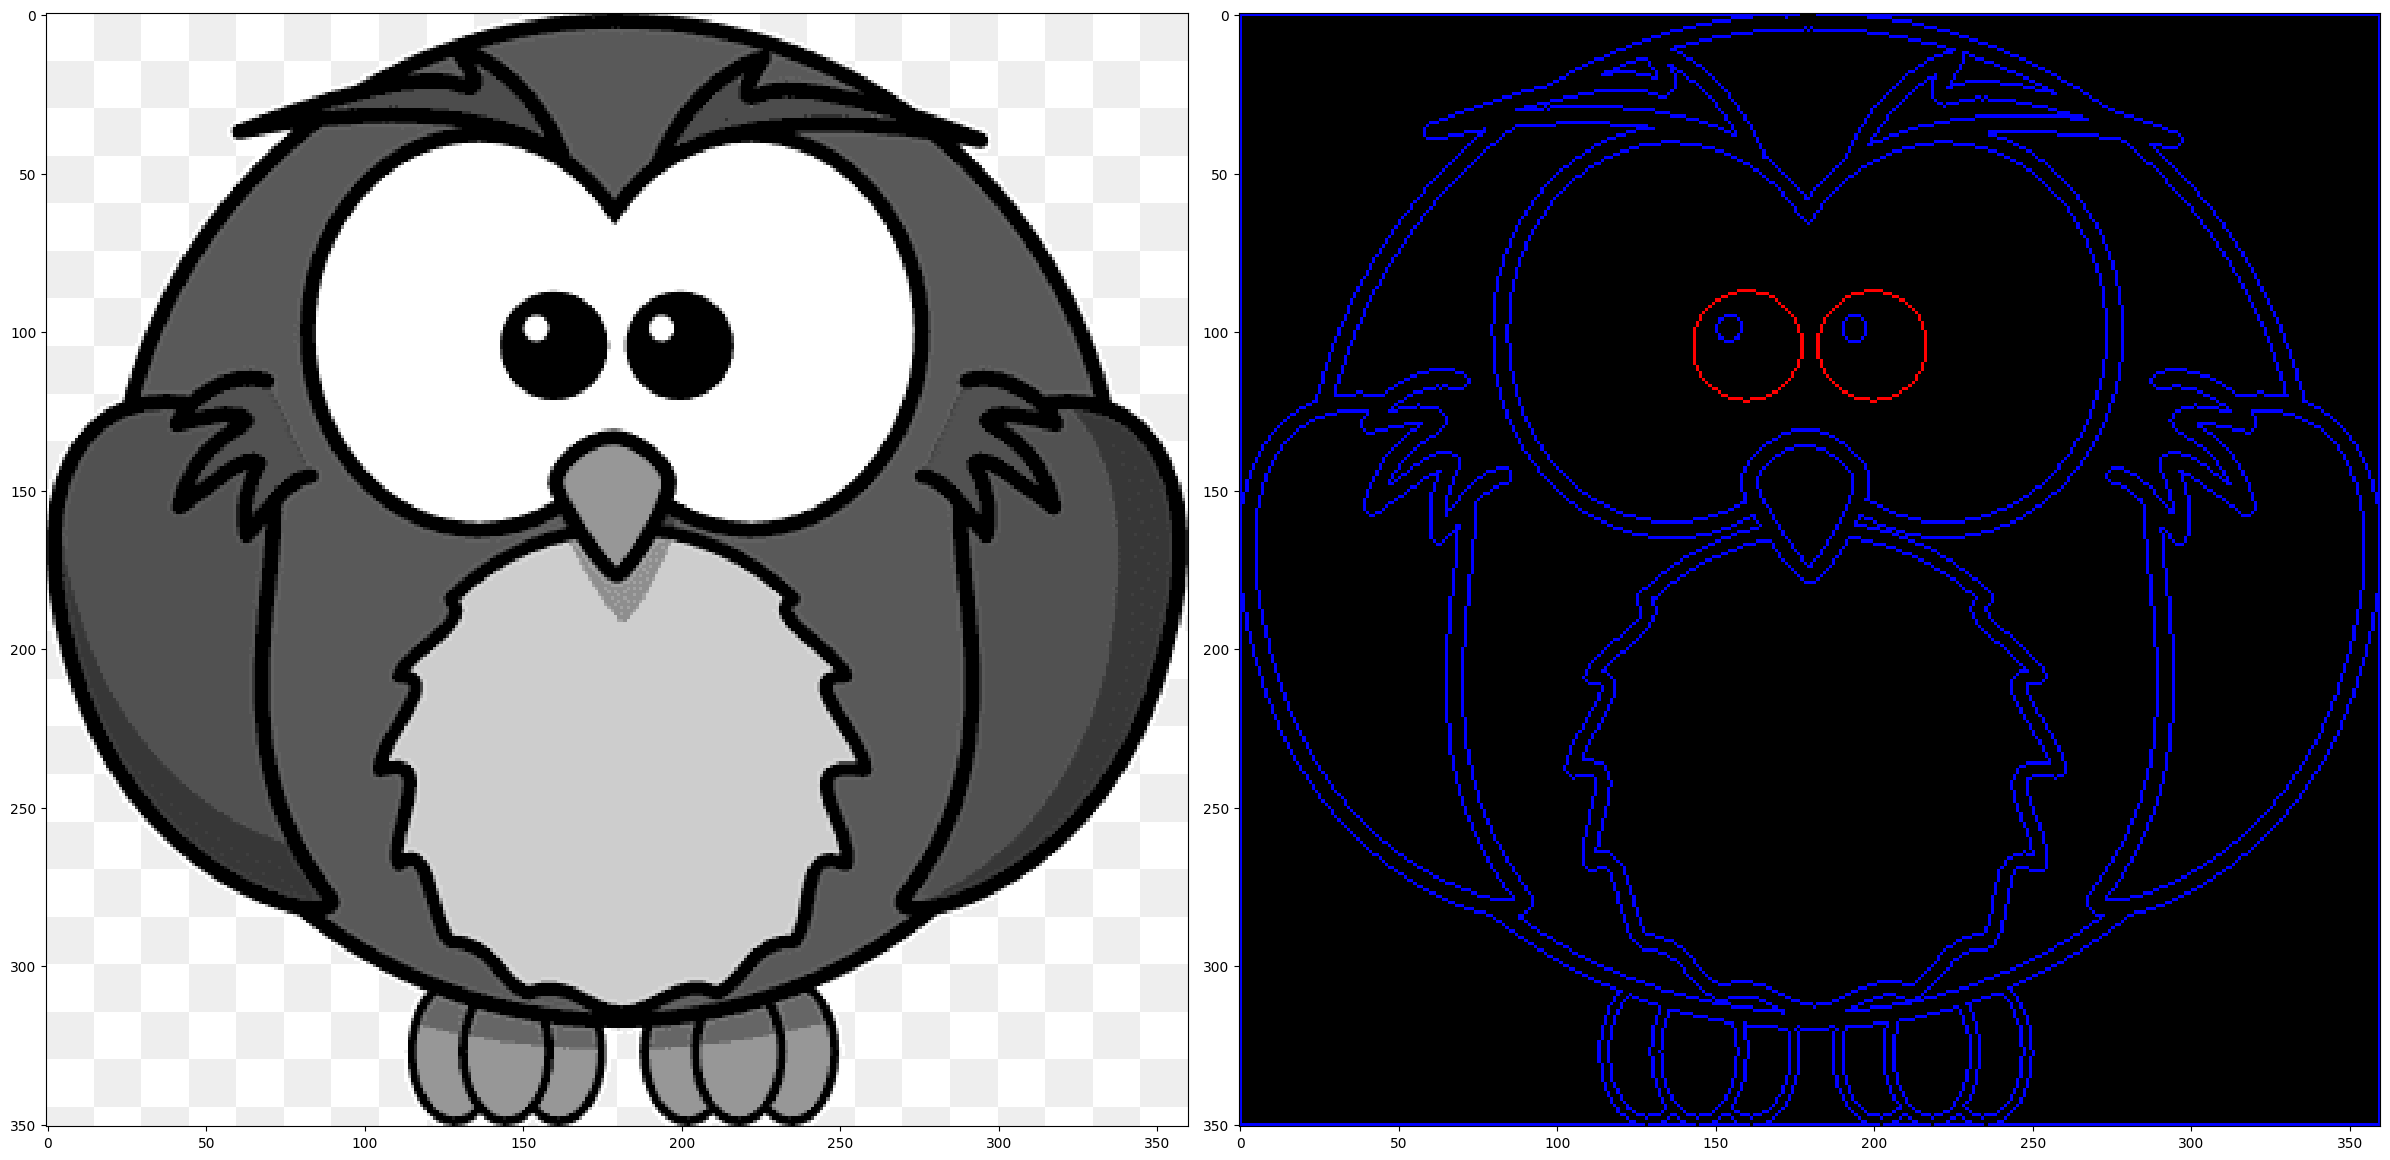

In [ ]:
show_contour_tracing('./result/baykus.png')

100%|██████████| 780/780 [00:07<00:00, 109.78it/s]


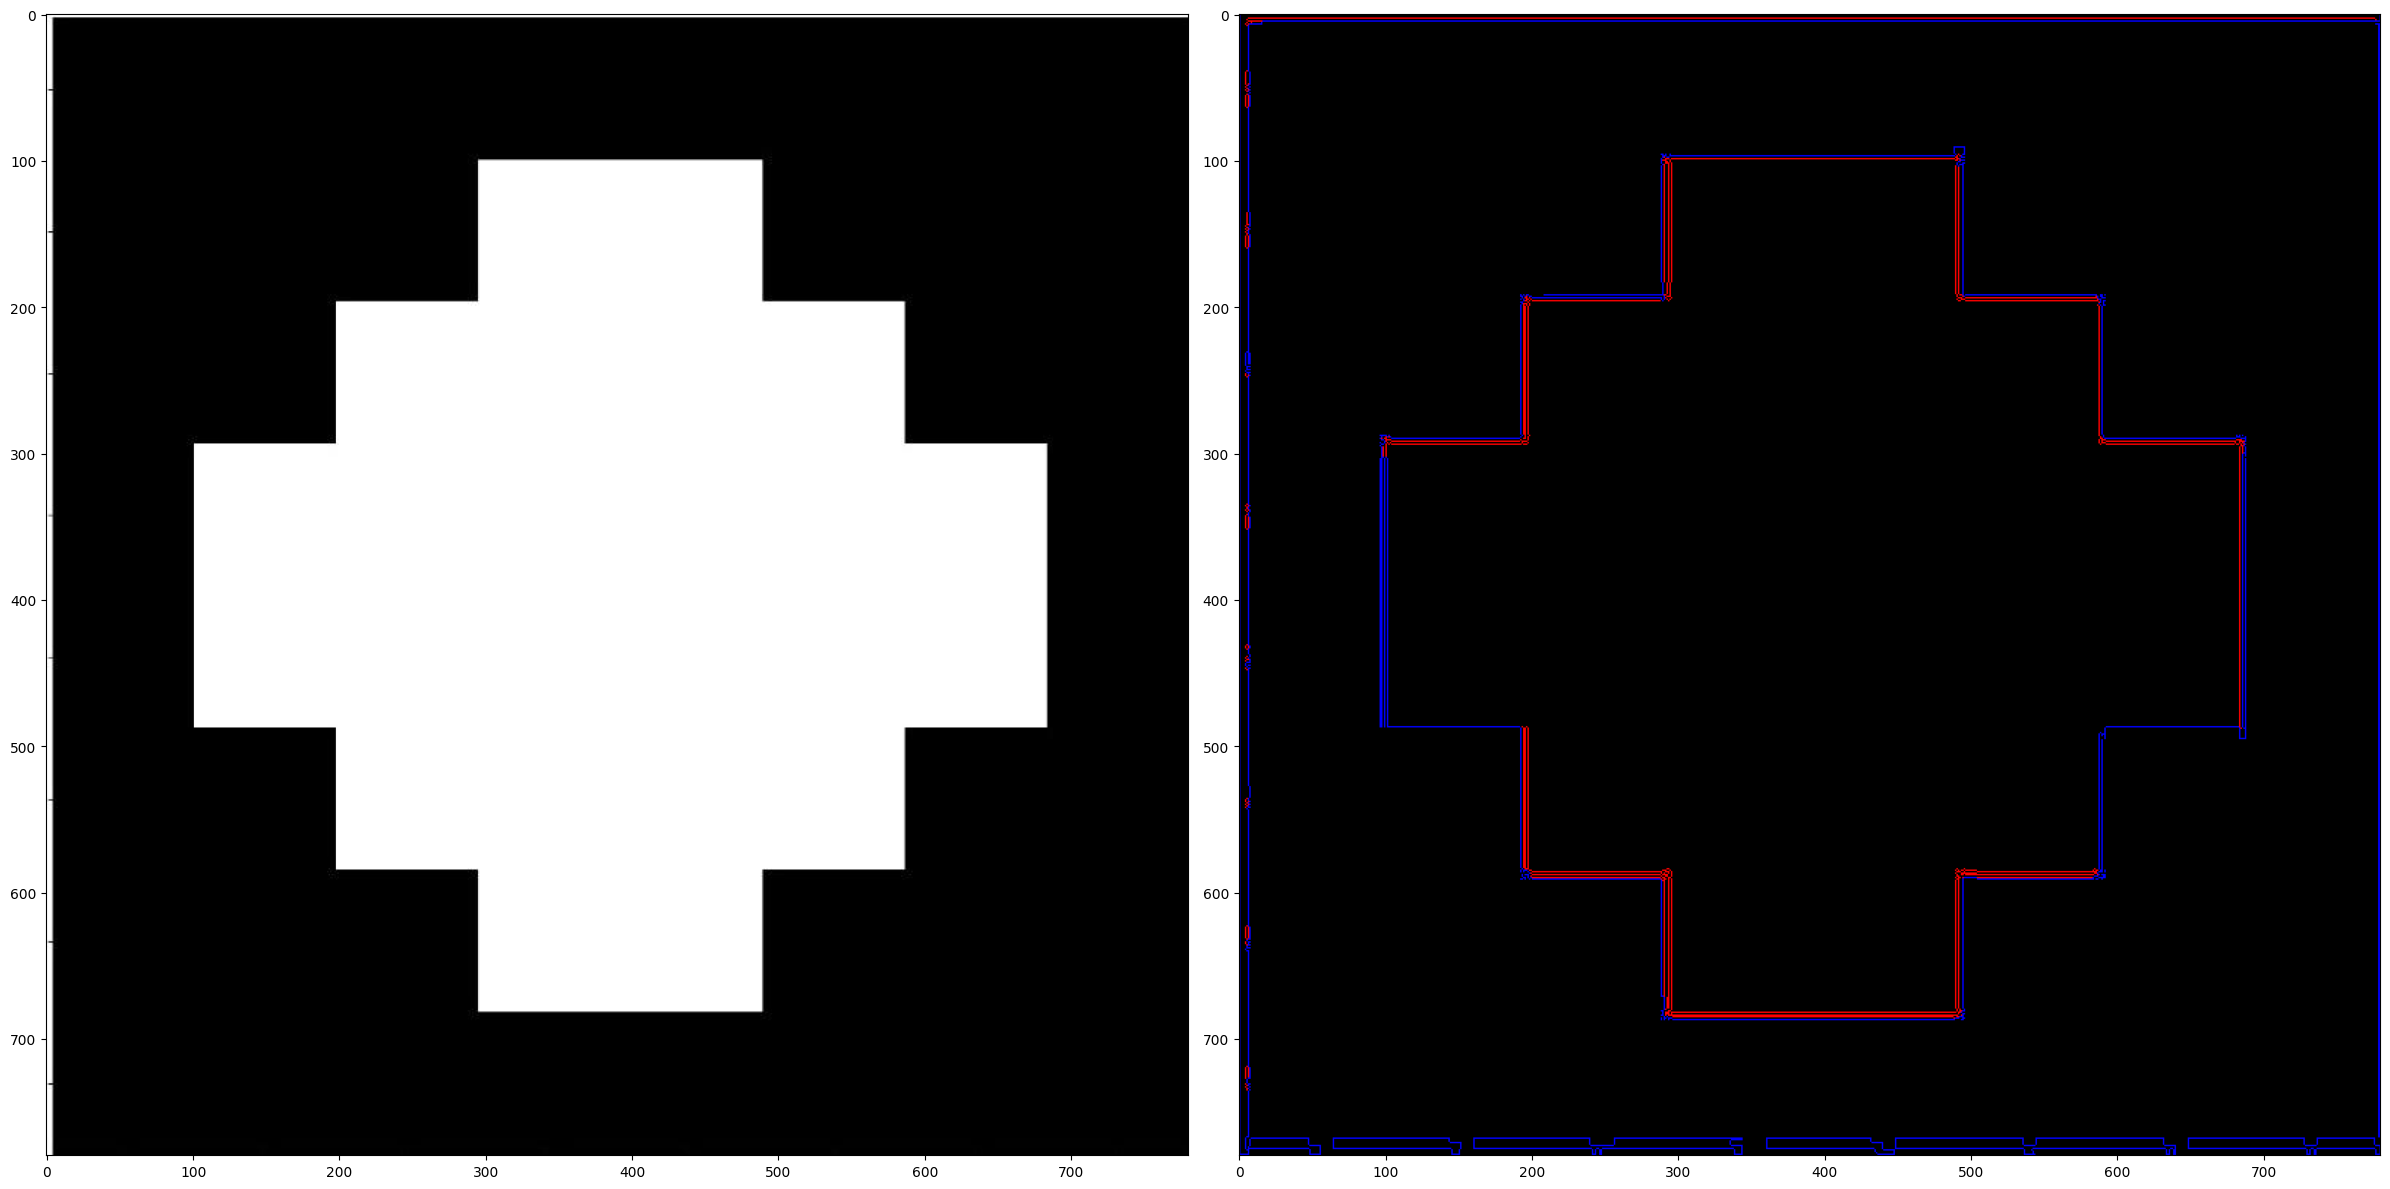

In [ ]:
show_contour_tracing('./result/sekil.jpg')

100%|██████████| 225/225 [00:01<00:00, 121.61it/s]


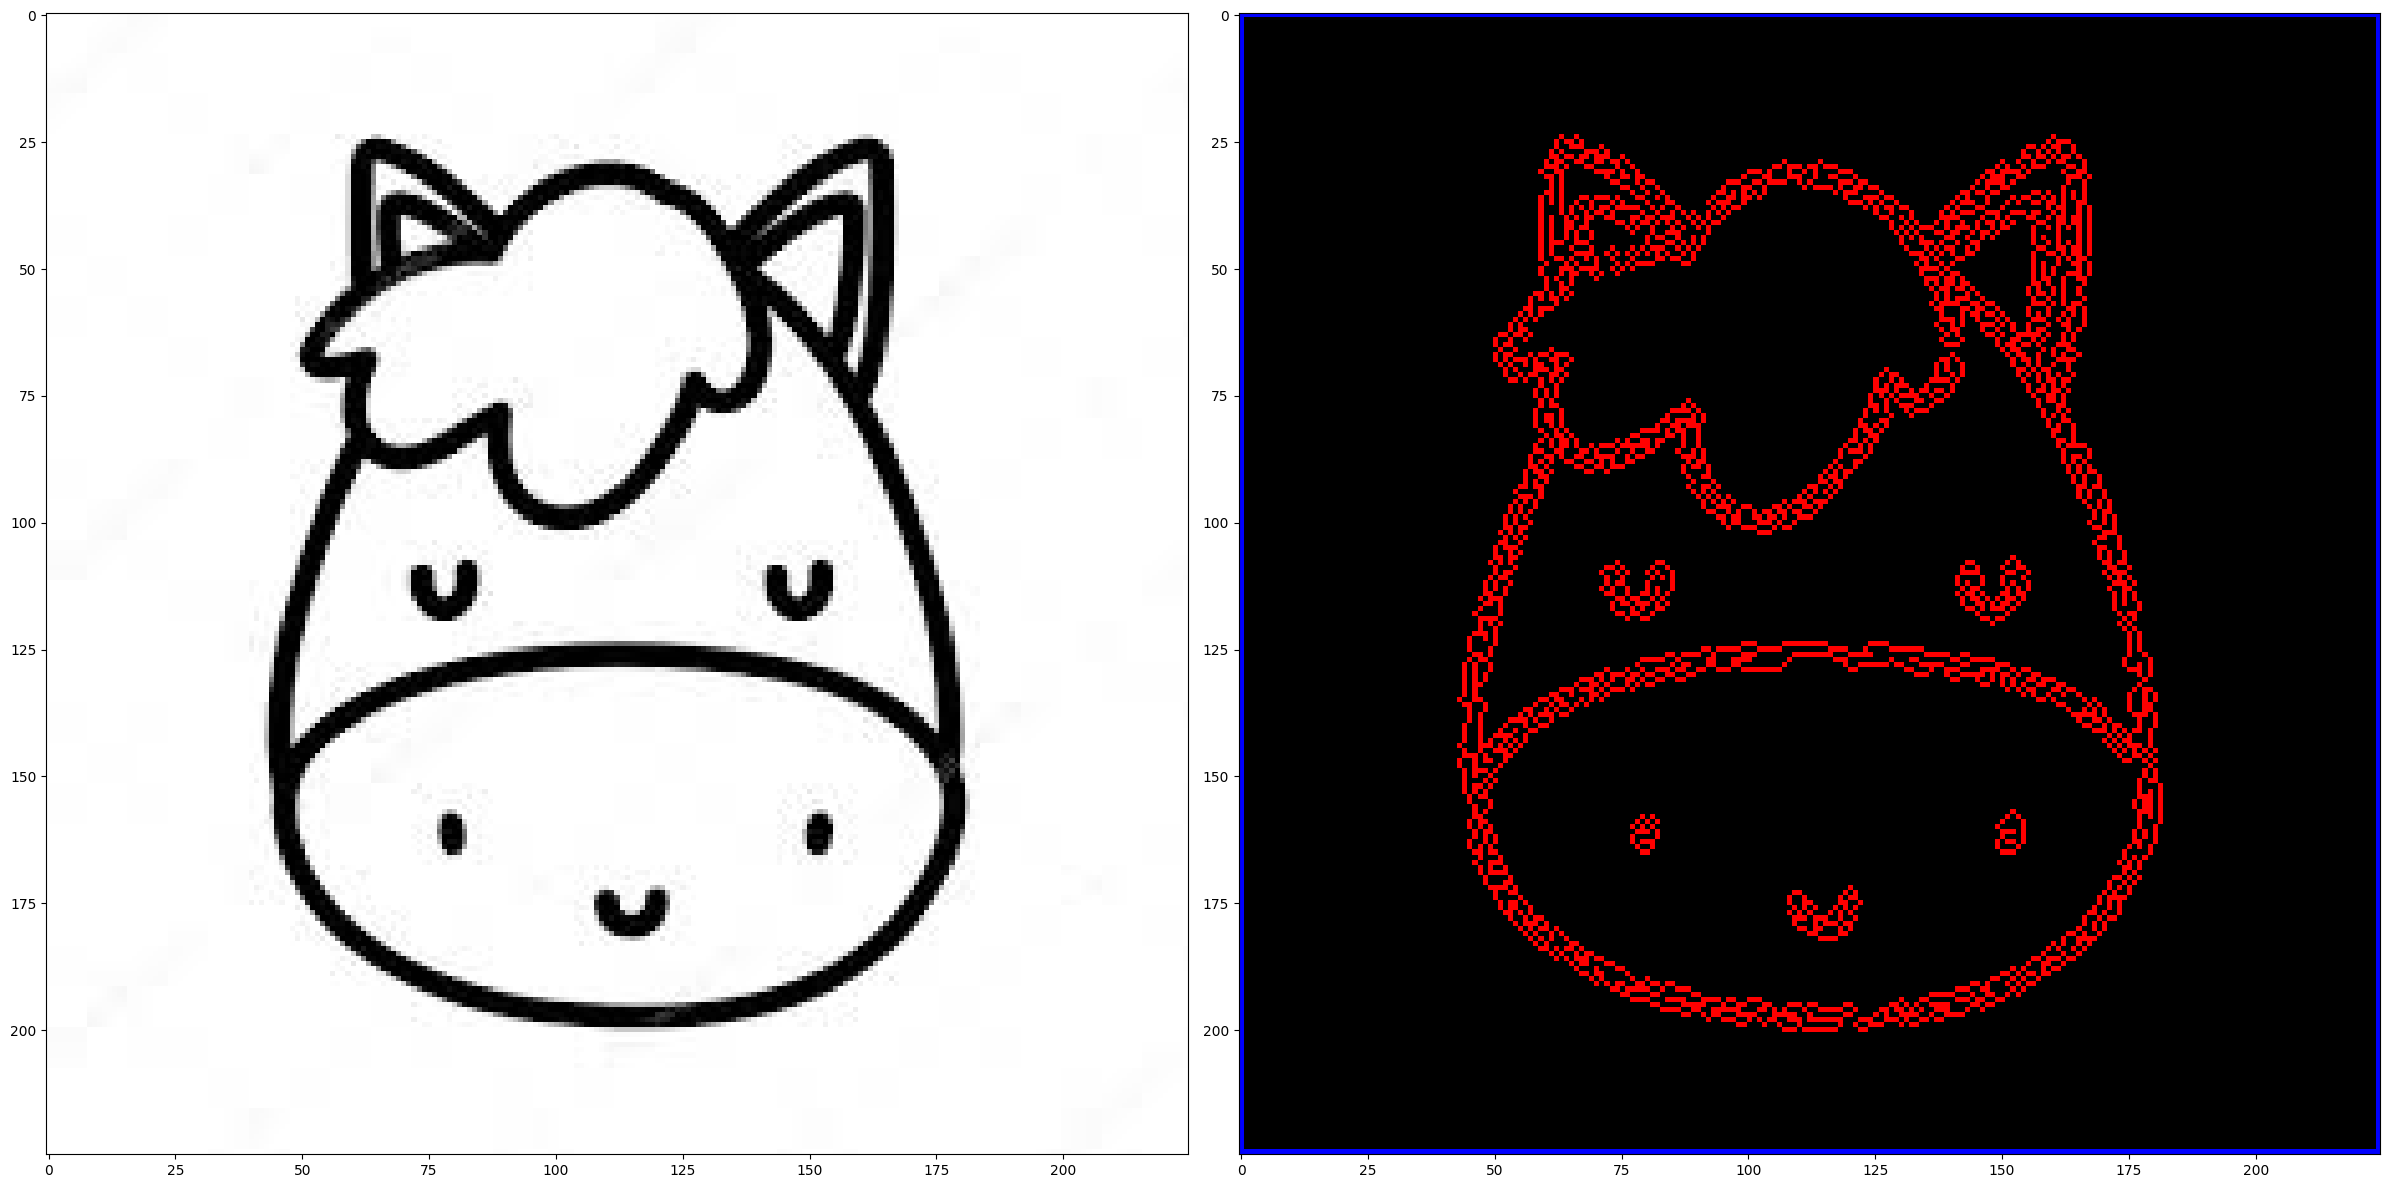

In [ ]:
show_contour_tracing('./result/inek.jpg')

100%|██████████| 225/225 [00:00<00:00, 236.28it/s]


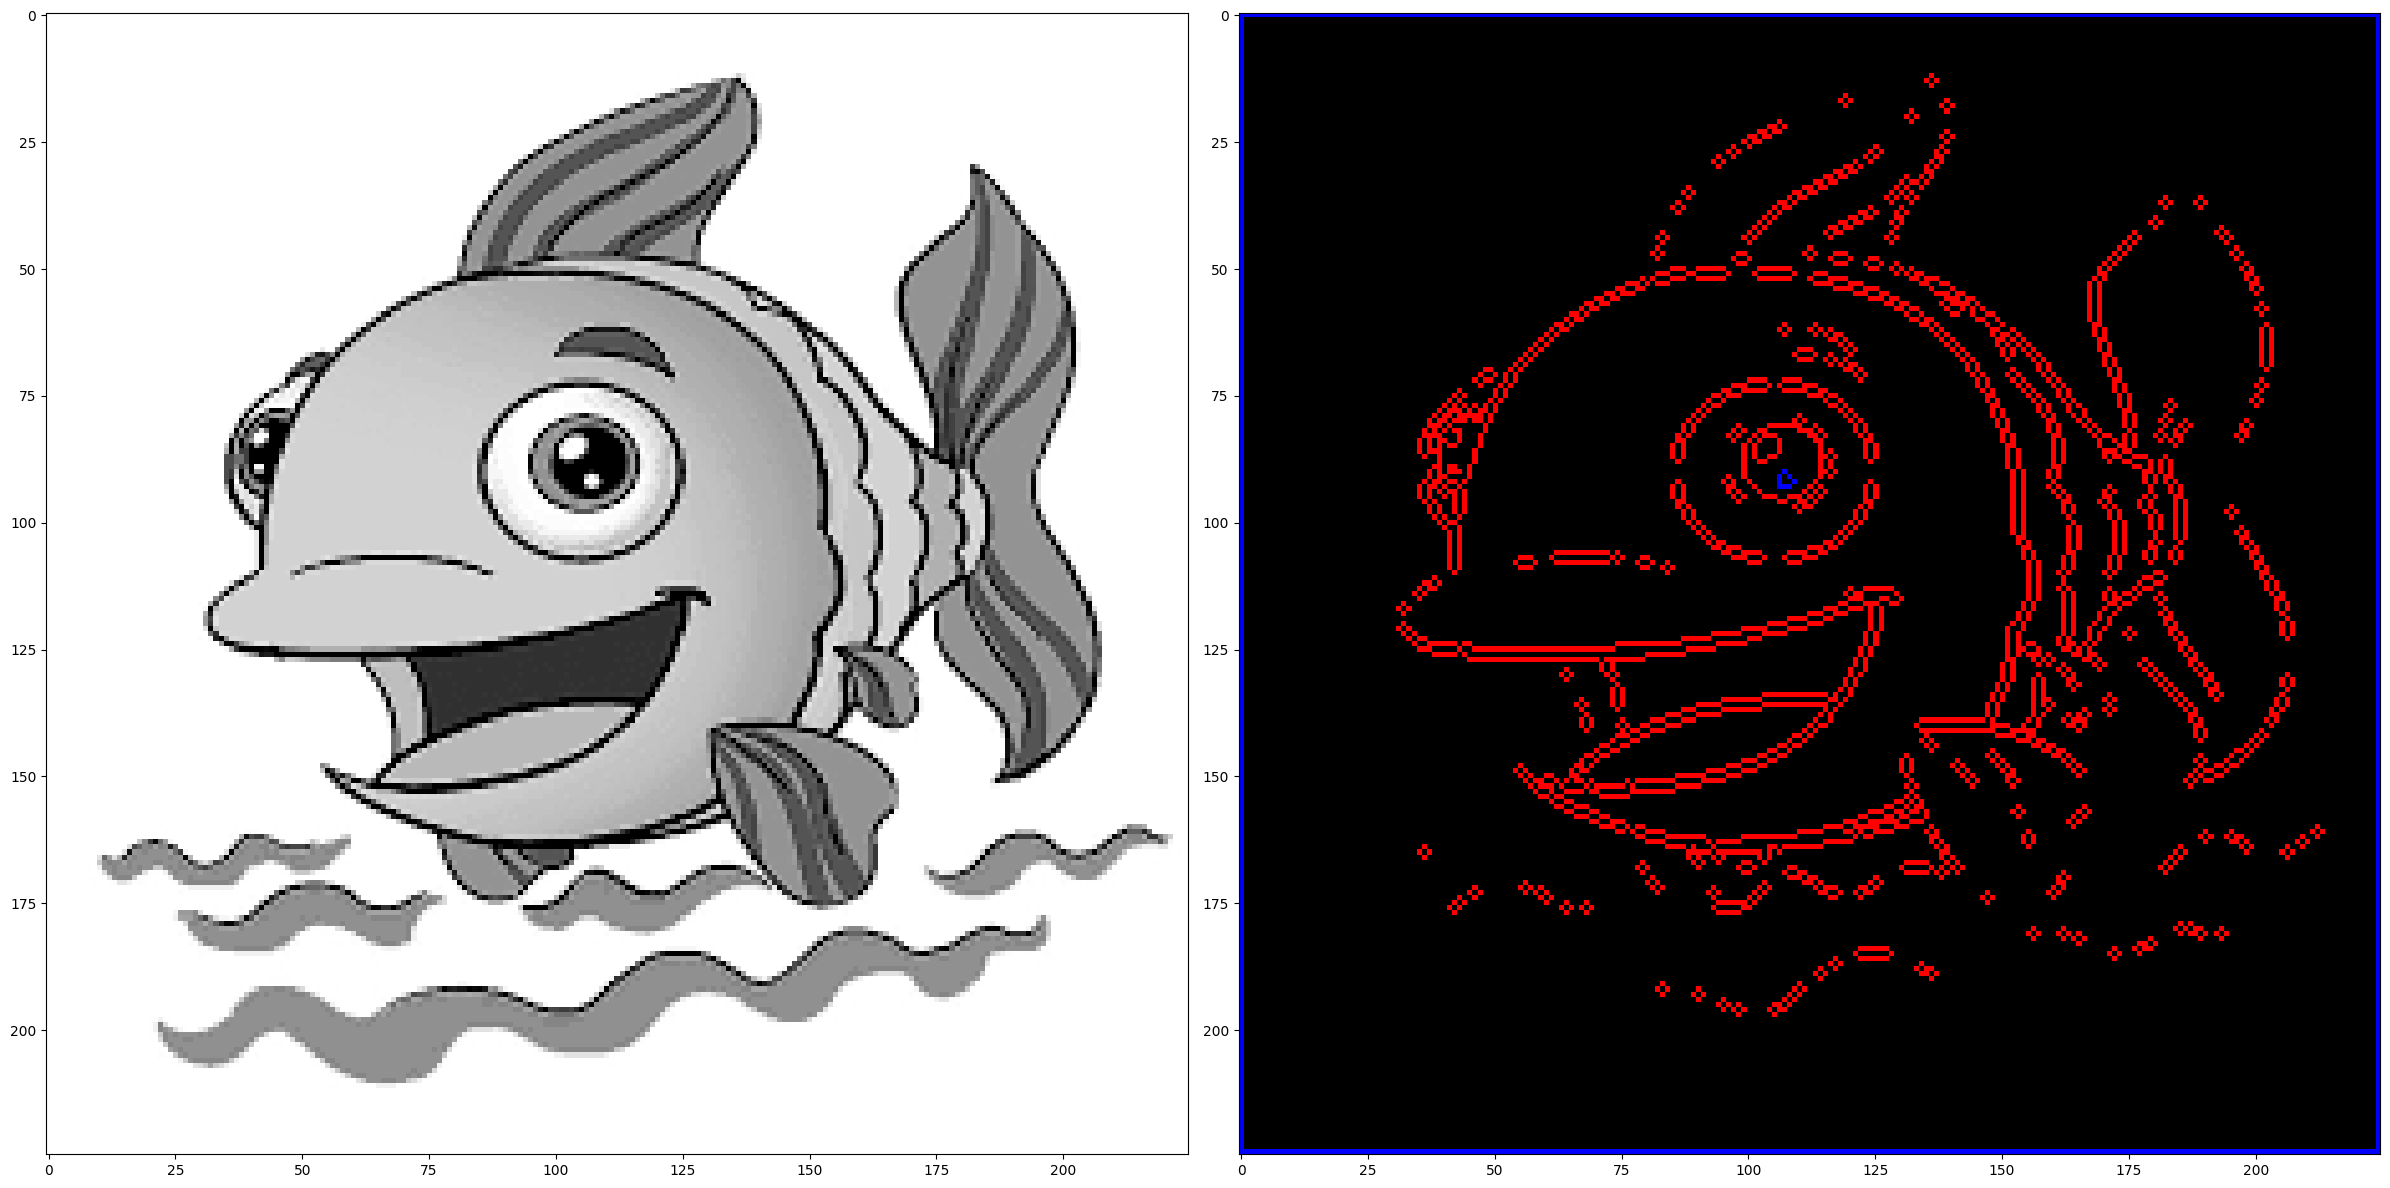

In [ ]:
show_contour_tracing('./result/balık.png')

100%|██████████| 505/505 [00:04<00:00, 106.33it/s]


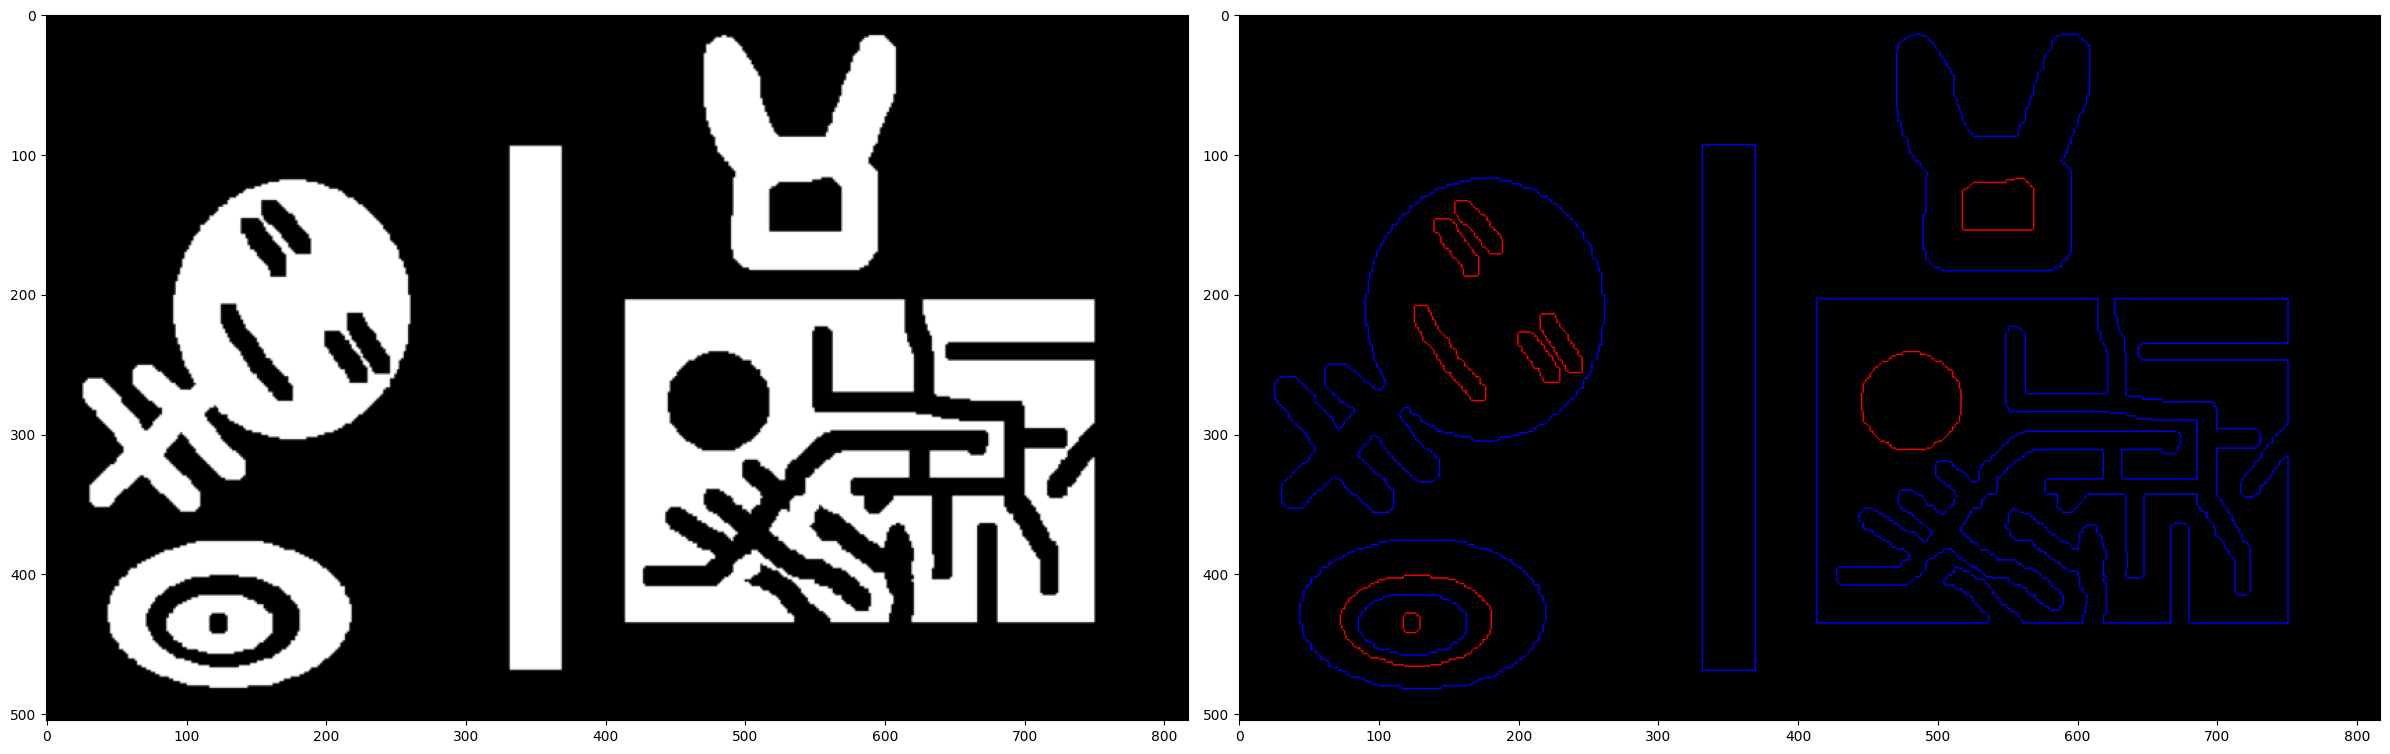

In [ ]:
show_contour_tracing('./result/yüz.png')

100%|██████████| 807/807 [00:06<00:00, 117.88it/s]


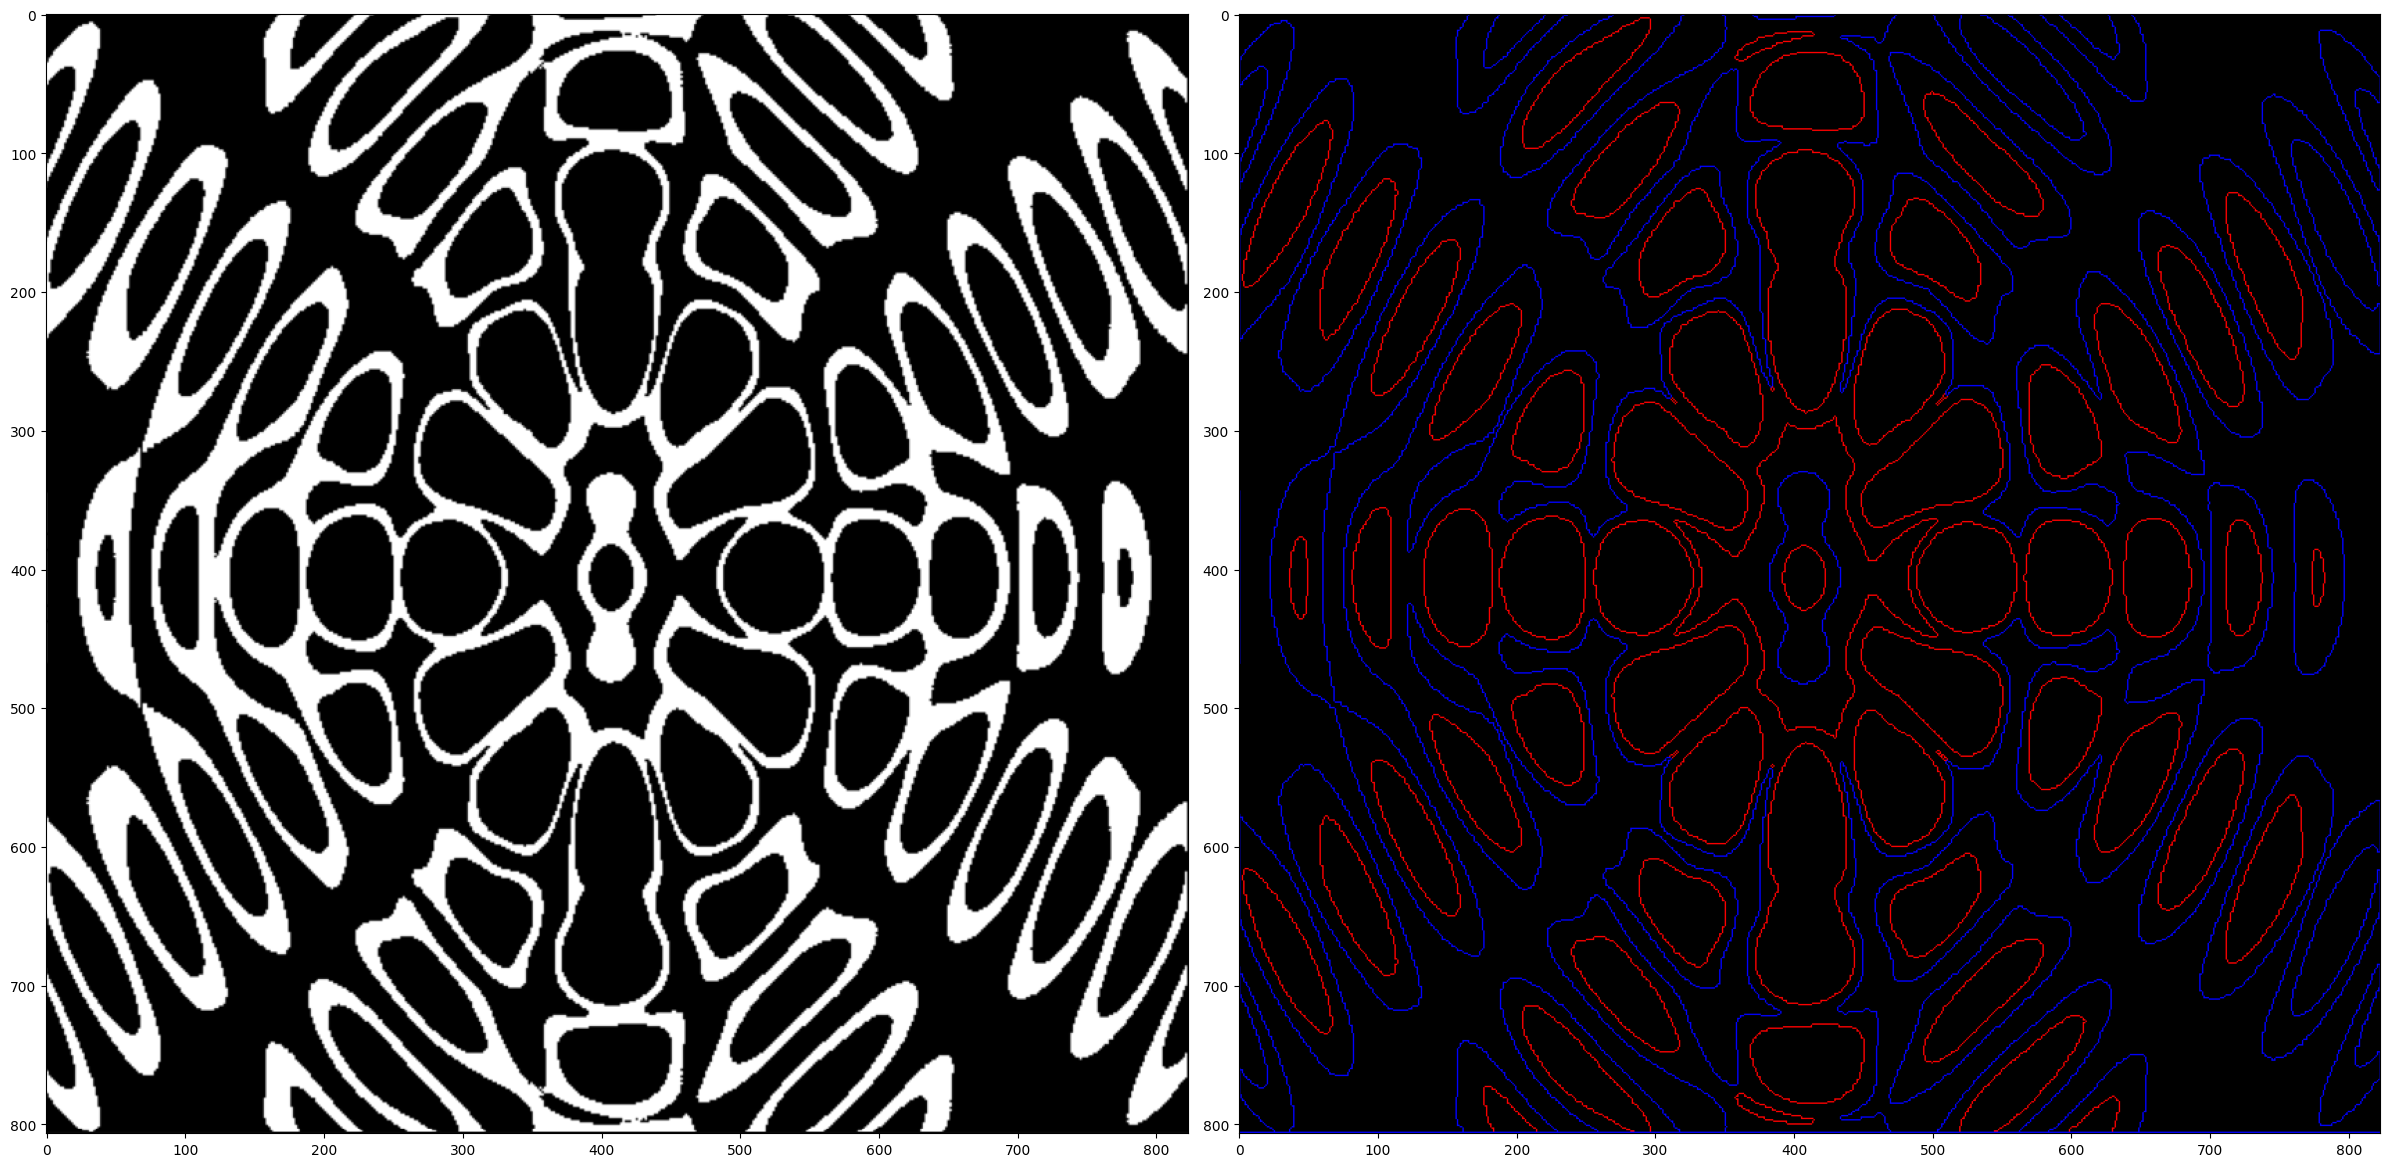

In [ ]:
show_contour_tracing('./result/dalga.png')